# PROYEK AKHIR SENTIMENT ANALYSIS SANBERCODE BOOTCAMP
### by Aditya Nur'ahya - aditya.nurahya17@gmail.com

#### Import library yang dibutuhkan

In [1]:
!pip install PySastrawi
!pip install tweepy==4.5.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, requests
import tweepy
import re, string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from urllib.request import urlopen
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import tqdm

     |████████████████████████████████| 210 kB 9.9 MB/s 
     |████████████████████████████████| 66 kB 3.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Business Understanding
#### Menentukan topik Tweets
Dalam analisis media sosial ini saya akan mengambil topik yang sedang banyak dibahas pada media sosial Twitter yaitu "Bupati Langkat"
Topik ini dalam beberapa waktu belakangan banyak dibahas dalam pemberitaan, sehingga menimbulkan opini publik yang beragam mengenai hal ini. Ini menjadikan sebuah peluang untuk mencari kecenderungan opini publik pada topik ini. Apakah topik ini mengarah kepada opini yang Positif ataukah Negatif, pun bisa bersifat netral di kalangan masyarakat.

### Data Collection
#### Melakukan Scrapping dengan API dari Twitter untuk Tweets yang berkaitan dengan topik yang ditargetkan

Load API token yang kita punya dari akun Developer Twitter

In [2]:
with open("token.json") as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

tokens.keys()

dict_keys(['bearer_token', 'api_key', 'api_key_secret', 'access_token', 'access_token_secret'])

Buat variable untuk otentikasi dan API

In [3]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Masukkan parameter yang kita butuhkan untuk penarikan Tweets

In [4]:
search_words = "Bupati Langkat"
date_since = "2022-01-23"
date_until = "2022-01-26"
search = search_words + " -filter:retweets"

In [5]:
response = tweepy.Cursor(api.search_tweets,
        q=search,
        lang="id",
        since_id=date_since,
        until=date_until).items(3000)

results = [(tweet.text) for tweet in response]
hasil = pd.DataFrame(data=results, columns=['tweet'])

Rate limit reached. Sleeping for: 862


In [6]:
hasil

,tweet
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...
1,pengen seperti bupati langkat punya penjara pr...
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup..."
3,Seorang warga yang berada di dalam kerangkeng ...
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...
...,...
2995,Dia bukan manusia Tapi iblis..\n\nUsut tuntas ...
2996,@LeeM1neraL Kab langkat itu kan adnya d sumut....
2997,Kerangkeng di Rumah Bupati Langkat Diakui untu...
2998,seperti zaman tahun kapan\n https://t.co/nCAIF...


Menyimpan dataset mentah kedalam file format csv

In [7]:
hasil.to_csv('tweets_bupati_langkat.csv', index=False)

### Data Preparation
#### Pada bagian ini data diproses hingga menghasilkan data yang bersih hingga bisa digunakan untuk analisis sentimen

In [8]:
df = pd.read_csv('tweets_bupati_langkat.csv')
df

,tweet
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...
1,pengen seperti bupati langkat punya penjara pr...
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup..."
3,Seorang warga yang berada di dalam kerangkeng ...
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...
...,...
2995,Dia bukan manusia Tapi iblis..\n\nUsut tuntas ...
2996,@LeeM1neraL Kab langkat itu kan adnya d sumut....
2997,Kerangkeng di Rumah Bupati Langkat Diakui untu...
2998,seperti zaman tahun kapan\n https://t.co/nCAIF...


Jadikan tweet menjadi tipe data string agar dapat di proses untuk tahap case folding

In [9]:
df['clean_tweet'] = df['tweet'].astype('str')

Menggunakan fungsi clean_text untuk case folding tweet yang kita dapatkan

In [10]:
def clean_text(tweet):
    tweet = tweet.lower() # text lowercase
    tweet = re.sub('@[^\s]+', '', tweet) # remove usernames
    tweet = re.sub('\[.*?\]', '', tweet) # remove square brackets
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # remove URLs
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet) # remove punctuation
    tweet = re.sub('\w*\d\w*', '', tweet) 
    tweet = re.sub('[‘’“”…]', '', tweet)
    tweet = re.sub('\n', ' ', tweet)
    tweet = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE).sub(r'',tweet)
    return tweet

    
tweet = lambda x: clean_text(x)

In [11]:
df['clean_tweet'] = pd.DataFrame(df['clean_tweet'].apply(tweet))
df.head()

,tweet,clean_tweet
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...,mabes polri selidiki dugaan perbudakan di ruma...
1,pengen seperti bupati langkat punya penjara pr...,pengen seperti bupati langkat punya penjara pr...
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup...",giliran kek gni cpt diusut noh bupati langka...
3,Seorang warga yang berada di dalam kerangkeng ...,seorang warga yang berada di dalam kerangkeng ...
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...,heboh penemuan kerangkeng di rumah bupati lang...


Menghilangkan stopwords bahasa Indonesia pada tweet

### Data Processing

#### Sentiment Analysis 

Sentiment Analysis dilakukan dengan mencocokan kata yang mengandung makna Positif dan Negatif pada list kata yang telah kita gunakan dari repository (https://github.com/riochr17/Analisis-Sentimen-ID) sebagai sentiment yang akan dicocokan dengan kata yang ada di dalam sebuah tweets

In [12]:
file = open("kata_positif.txt","w")
url = urlopen("https://raw.githubusercontent.com/riochr17/Analisis-Sentimen-ID/master/kamus/positive_keyword.txt")
for line in url:
    file.write(line.decode("utf-8"))
file.close()

file = open("kata_negatif.txt","w")
url = urlopen("https://raw.githubusercontent.com/riochr17/Analisis-Sentimen-ID/master/kamus/negative_keyword.txt")
for line in url:
    file.write(line.decode("utf-8"))
file.close()

In [13]:
#tarik data kedalam list
items = df['clean_tweet'].tolist()

pos_list = open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list = open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()  
list_anti = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm']
for item in items:
    print(item.strip())
    tweets = item.strip().split() #tokenization
    
    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif
    
    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_pos, ['negatif'])
                    count_n += 1
                else:
                    print(kata_pos, ['positif'])
                    count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_neg, ['positif'])
                    count_p += 1
                else:
                    print(kata_neg, ['negatif'])
                    count_n += 1
    
    print("positif: "+str(count_p))
    print("negatif: "+str(count_n))


Streaming output truncated to the last 5000 lines.
negatif: 0
lpsk siap lindungi saksi perbudakan bupati langkat   inilahcom  inilahdotcom
siap
 ['positif']
positif: 1
negatif: 0
bupati langkat nonaktif emang gk ngotak  bisa bisanyaa dia nih pa ndak punya hati nurani   ya atau gk pernah disusu
emang
 ['negatif']
bisa
 ['positif']
positif: 1
negatif: 1
kejam  ada kerangkeng di rumah bupati langkat  migrant care  tempat menyekap pekerja sawit di ladangnya  baca selen
kejam
 ['negatif']
positif: 0
negatif: 1
kerangkeng manusia ditemukan di rumahnya  bupati langkat dilaporkan ke komnas ham
positif: 0
negatif: 0
kerangkeng manusia ditemukan di rumahnya  bupati langkat dilaporkan ke komnas ham
positif: 0
negatif: 0
ini udah di luar prikemanusiaan dan peradaban  usut tuntas bupati langkat hukum seberat beratnya  cuman m
tuntas
 ['positif']
positif: 1
negatif: 0
ada kerangkeng manusia di rumah bupati langkat  sumut   kerangkeng itu ditemukan saat tim kpk menggeledah rumah bup
positif: 0
negati

In [14]:
hasil = []
list_anti = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm']

for item in items:
    print(item.strip())
    tweets = item.strip().split() #tokenization
    
    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif
    
    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_pos, ['negatif'])
                    count_n += 1
                else:
                    print(kata_pos, ['positif'])
                    count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_neg, ['positif'])
                    count_p += 1
                else:
                    print(kata_neg, ['negatif'])
                    count_n += 1
    
    print ("positif: " + str(count_p))
    print ("negatif: " + str(count_n))
    hasil.append(count_p - count_n)
    
print ("Nilai rata-rata: " + str(np.mean(hasil)))
print ("Standar deviasi: " + str(np.std(hasil)))

Streaming output truncated to the last 5000 lines.
siap
 ['positif']
positif: 1
negatif: 0
bupati langkat nonaktif emang gk ngotak  bisa bisanyaa dia nih pa ndak punya hati nurani   ya atau gk pernah disusu
emang
 ['negatif']
bisa
 ['positif']
positif: 1
negatif: 1
kejam  ada kerangkeng di rumah bupati langkat  migrant care  tempat menyekap pekerja sawit di ladangnya  baca selen
kejam
 ['negatif']
positif: 0
negatif: 1
kerangkeng manusia ditemukan di rumahnya  bupati langkat dilaporkan ke komnas ham
positif: 0
negatif: 0
kerangkeng manusia ditemukan di rumahnya  bupati langkat dilaporkan ke komnas ham
positif: 0
negatif: 0
ini udah di luar prikemanusiaan dan peradaban  usut tuntas bupati langkat hukum seberat beratnya  cuman m
tuntas
 ['positif']
positif: 1
negatif: 0
ada kerangkeng manusia di rumah bupati langkat  sumut   kerangkeng itu ditemukan saat tim kpk menggeledah rumah bup
positif: 0
negatif: 0
diduga lakukan perbudakan manusia  tokoh nu  bupati langkat wajib dihukum berat
did

Hasil dari pencocokan itu akan menghasilkan nilai yang menjadi pola dari sentiment yang telah dilakukan. Jika Nilai sentiment x < 0, maka sentiment bernilai Negatif. Jika sentiment x > 0, maka sentiment bernilai Positif. Dan Jika sentiment x = 0, maka sentiment bernilai Netral

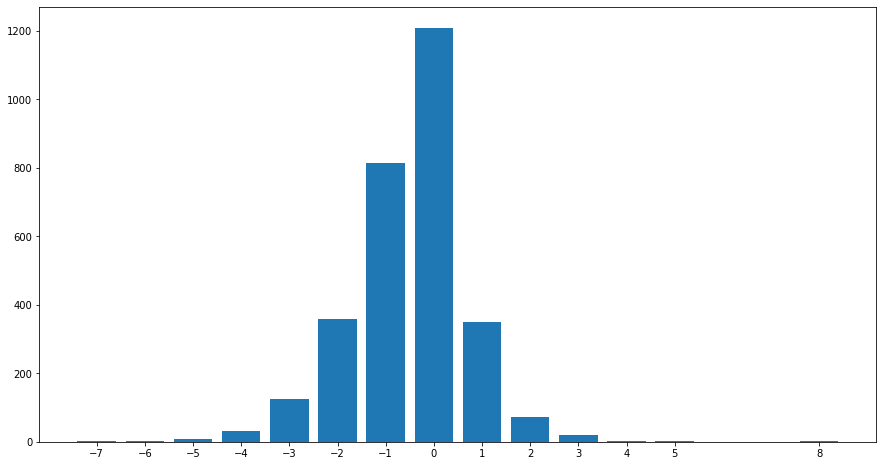

In [15]:
plt.figure(figsize=(15, 8))
labels, counts = np.unique(hasil, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [16]:
df['sentiment'] = hasil

In [17]:
def condition(x):
    if x > 0:
        return 'Positive'
    elif x < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [18]:
df['sentiment'] = df['sentiment'].apply(condition)
df.head()

,tweet,clean_tweet,sentiment
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...,mabes polri selidiki dugaan perbudakan di ruma...,Negative
1,pengen seperti bupati langkat punya penjara pr...,pengen seperti bupati langkat punya penjara pr...,Neutral
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup...",giliran kek gni cpt diusut noh bupati langka...,Negative
3,Seorang warga yang berada di dalam kerangkeng ...,seorang warga yang berada di dalam kerangkeng ...,Neutral
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...,heboh penemuan kerangkeng di rumah bupati lang...,Neutral


In [19]:
df.to_csv('Sentiment_Bupati_Langkat.csv', columns=['tweet', 'clean_tweet', 'sentiment'], index=False)

In [20]:
df_sentiment = pd.read_csv('Sentiment_Bupati_Langkat.csv')
df_sentiment

,tweet,clean_tweet,sentiment
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...,mabes polri selidiki dugaan perbudakan di ruma...,Negative
1,pengen seperti bupati langkat punya penjara pr...,pengen seperti bupati langkat punya penjara pr...,Neutral
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup...",giliran kek gni cpt diusut noh bupati langka...,Negative
3,Seorang warga yang berada di dalam kerangkeng ...,seorang warga yang berada di dalam kerangkeng ...,Neutral
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...,heboh penemuan kerangkeng di rumah bupati lang...,Neutral
...,...,...,...
2995,Dia bukan manusia Tapi iblis..\n\nUsut tuntas ...,dia bukan manusia tapi iblis usut tuntas ka...,Negative
2996,@LeeM1neraL Kab langkat itu kan adnya d sumut....,kab langkat itu kan adnya d sumut nah coba g...,Negative
2997,Kerangkeng di Rumah Bupati Langkat Diakui untu...,kerangkeng di rumah bupati langkat diakui untu...,Negative
2998,seperti zaman tahun kapan\n https://t.co/nCAIF...,seperti zaman tahun kapan,Neutral


In [21]:
df_sentiment['sentiment'].value_counts()

Negative    1343
Neutral     1209
Positive     448
Name: sentiment, dtype: int64

In [22]:
nltk.download('stopwords')
swords = set().union(stopwords.words('indonesian'))

df['clean_tweet1'] = (df['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (swords)])))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweet,clean_tweet,sentiment,clean_tweet1
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...,mabes polri selidiki dugaan perbudakan di ruma...,Negative,mabes polri selidiki dugaan perbudakan rumah b...
1,pengen seperti bupati langkat punya penjara pr...,pengen seperti bupati langkat punya penjara pr...,Neutral,pengen bupati langkat penjara pribadi memenjar...
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup...",giliran kek gni cpt diusut noh bupati langka...,Negative,giliran kek gni cpt diusut noh bupati langkat ...
3,Seorang warga yang berada di dalam kerangkeng ...,seorang warga yang berada di dalam kerangkeng ...,Neutral,warga kerangkeng rumah bupati langkat terbit r...
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...,heboh penemuan kerangkeng di rumah bupati lang...,Neutral,heboh penemuan kerangkeng rumah bupati langkat...


Stemming untuk menghilangkan kata yang berimbuhan untuk mengembalikan kata pada bentuk dasarnya. Dengan menggunakan library Sastrawi pada package StemmerFactory khusus untuk bahasa Indonesia

In [23]:
text = df['clean_tweet1']

factory = StemmerFactory()
stemmer = factory.create_stemmer()

list_hasil = text

output = [(stemmer.stem(token)) for token in list_hasil]

df['clean_tweet1'] = output
df.head()

,tweet,clean_tweet,sentiment,clean_tweet1
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...,mabes polri selidiki dugaan perbudakan di ruma...,Negative,mabes polri selidik duga budak rumah bupati no...
1,pengen seperti bupati langkat punya penjara pr...,pengen seperti bupati langkat punya penjara pr...,Neutral,ken bupati langkat penjara pribadi penjara hati
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup...",giliran kek gni cpt diusut noh bupati langka...,Negative,gilir kek gni cpt usut noh bupati langkat tang...
3,Seorang warga yang berada di dalam kerangkeng ...,seorang warga yang berada di dalam kerangkeng ...,Neutral,warga kerangkeng rumah bupati langkat terbit r...
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...,heboh penemuan kerangkeng di rumah bupati lang...,Neutral,heboh temu kerangkeng rumah bupati langkat ora...


Membuat tweet menjadi kata - kata yang terpisah menggunakan metode Tokenizing

In [24]:
nltk.download('punkt')
df['token'] = df['clean_tweet1'].apply(lambda x: word_tokenize(str(x)))
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,tweet,clean_tweet,sentiment,clean_tweet1,token
0,Mabes Polri Selidiki Dugaan Perbudakan di Ruma...,mabes polri selidiki dugaan perbudakan di ruma...,Negative,mabes polri selidik duga budak rumah bupati no...,"[mabes, polri, selidik, duga, budak, rumah, bu..."
1,pengen seperti bupati langkat punya penjara pr...,pengen seperti bupati langkat punya penjara pr...,Neutral,ken bupati langkat penjara pribadi penjara hati,"[ken, bupati, langkat, penjara, pribadi, penja..."
2,"@AREAJULID Giliran kek gni cpt diusut, noh bup...",giliran kek gni cpt diusut noh bupati langka...,Negative,gilir kek gni cpt usut noh bupati langkat tang...,"[gilir, kek, gni, cpt, usut, noh, bupati, lang..."
3,Seorang warga yang berada di dalam kerangkeng ...,seorang warga yang berada di dalam kerangkeng ...,Neutral,warga kerangkeng rumah bupati langkat terbit r...,"[warga, kerangkeng, rumah, bupati, langkat, te..."
4,Heboh Penemuan Kerangkeng Di Rumah Bupati Lang...,heboh penemuan kerangkeng di rumah bupati lang...,Neutral,heboh temu kerangkeng rumah bupati langkat ora...,"[heboh, temu, kerangkeng, rumah, bupati, langk..."


#### Topic Modelling

In [25]:
data_berita = [berita.split() for berita in df["clean_tweet1"]]
data_berita

[['mabes',
  'polri',
  'selidik',
  'duga',
  'budak',
  'rumah',
  'bupati',
  'nonaktif',
  'langkat'],
 ['ken', 'bupati', 'langkat', 'penjara', 'pribadi', 'penjara', 'hati'],
 ['gilir',
  'kek',
  'gni',
  'cpt',
  'usut',
  'noh',
  'bupati',
  'langkat',
  'tangkap',
  'hukum',
  'sklian'],
 ['warga',
  'kerangkeng',
  'rumah',
  'bupati',
  'langkat',
  'terbit',
  'rencana',
  'perangin',
  'angin',
  'fredi',
  'jonathan',
  'm'],
 ['heboh',
  'temu',
  'kerangkeng',
  'rumah',
  'bupati',
  'langkat',
  'orang',
  'dalam'],
 ['kalo',
  'lapas',
  'sukamiskin',
  'kaya',
  'rumah',
  'bupati',
  'langkat',
  'seru',
  'sih',
  'koruptor',
  'banyak',
  'usaha',
  'kelapa',
  'sawit',
  'diberda'],
 ['budak',
  'bupati',
  'langkat',
  'ksp',
  'pasti',
  'laku',
  'hukum',
  'berat',
  'kas'],
 ['budak',
  'bupati',
  'langkat',
  'ksp',
  'pasti',
  'laku',
  'hukum',
  'berat',
  'kas'],
 ['bupati',
  'langkat',
  'pegang',
  'kartu',
  'sampe',
  'dicebokin',
  'mabes',
  '

In [26]:
dictionary = corpora.Dictionary(data_berita)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_berita]

In [27]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

In [28]:
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.081*"bupati" + 0.073*"langkat" + 0.043*"kerja" + 0.026*"sawit" + '
  '0.018*"budak" + 0.018*"ya" + 0.012*"praktik" + 0.012*"gak" + 0.011*"gila" + '
  '0.010*"kapolda"'),
 (1,
  '0.067*"langkat" + 0.065*"bupati" + 0.036*"terbit" + 0.029*"rencana" + '
  '0.023*"angin" + 0.022*"perangin" + 0.022*"laku" + 0.021*"hukum" + '
  '0.020*"budak" + 0.017*"care"'),
 (2,
  '0.121*"bupati" + 0.113*"langkat" + 0.037*"kpk" + 0.035*"penjara" + '
  '0.027*"orang" + 0.020*"modern" + 0.019*"sumut" + 0.016*"biadab" + '
  '0.015*"rumah" + 0.014*"tangkap"'),
 (3,
  '0.030*"yg" + 0.028*"ott" + 0.022*"korupsi" + 0.019*"berita" + 0.019*"baca" '
  '+ 0.015*"ga" + 0.012*"kena" + 0.011*"sel" + 0.010*"bener" + 0.010*"jabat"'),
 (4,
  '0.103*"kerangkeng" + 0.098*"bupati" + 0.097*"langkat" + 0.086*"rumah" + '
  '0.083*"manusia" + 0.038*"budak" + 0.035*"duga" + 0.030*"temu" + '
  '0.013*"polisi" + 0.013*"ham"')]


Didapatkan dari Topic Extraction bahwa 5 topic teratas ditampilkan pada output diatas

### Data Analysis

##### Distribusi Frekuensi jumlah huruf pada suatu data

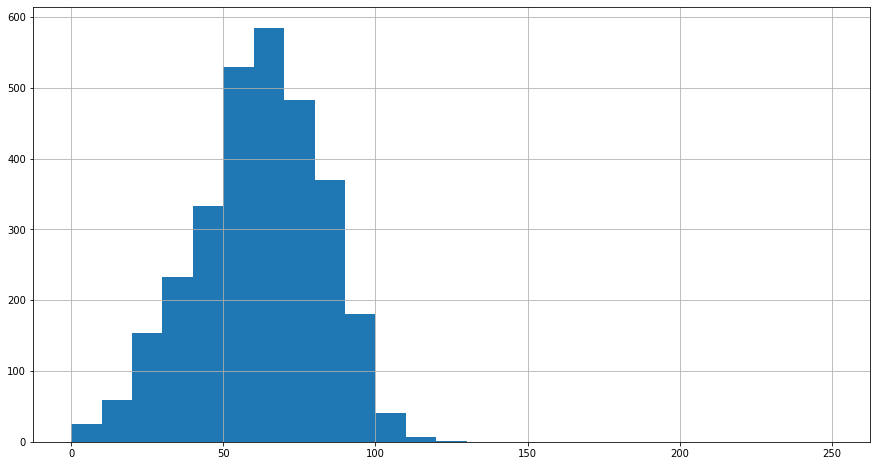

In [29]:
plt.figure(figsize=(15, 8))
bin_range = np.arange(0, 260, 10)
df['clean_tweet1'].str.len().hist(bins=bin_range)
plt.show()

##### Distribusi Frekuensi jumlah kata pada suatu data


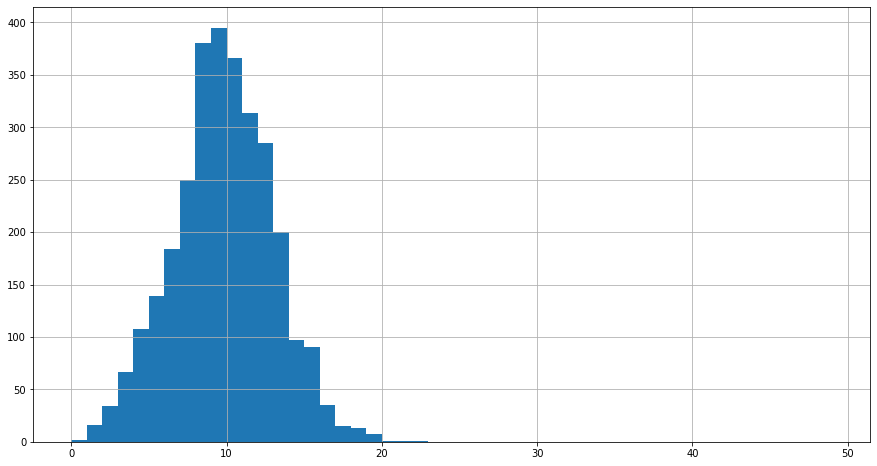

In [30]:
plt.figure(figsize=(15, 8))
bin_range = np.arange(0, 50)
df['clean_tweet1'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.show()

##### Distribusi Frekuensi panjang kata rata-rata pada suatu data


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


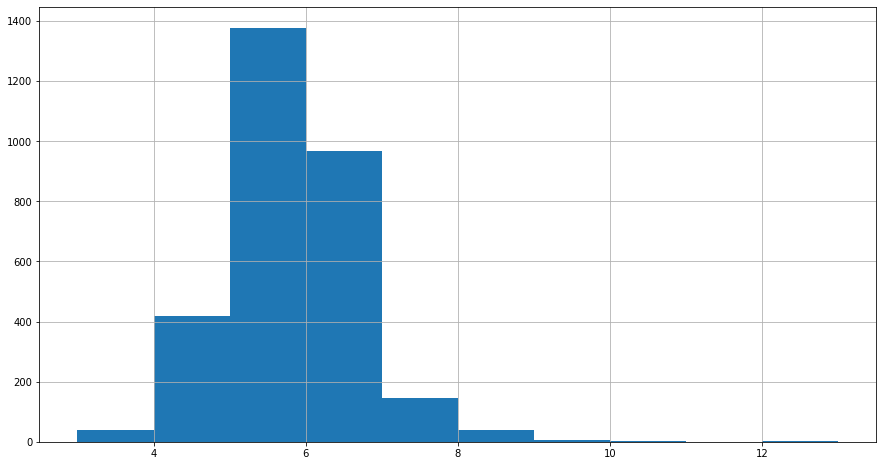

In [31]:
plt.figure(figsize=(15, 8))
df['clean_tweet1'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

##### FreqDist

In [32]:
news_title = [word for news in df['token'] for word in news]
fqdist = FreqDist(news_title)

print(fqdist)

<FreqDist with 3963 samples and 27977 outcomes>


##### Most Common Word

In [33]:
most_common_word = fqdist.most_common(20)
print(most_common_word)

[('bupati', 2534), ('langkat', 2455), ('kerangkeng', 991), ('rumah', 881), ('manusia', 726), ('budak', 475), ('duga', 322), ('temu', 271), ('penjara', 270), ('kpk', 243), ('orang', 217), ('yg', 206), ('kerja', 197), ('terbit', 184), ('polisi', 183), ('rencana', 149), ('nonaktif', 129), ('hukum', 121), ('sumut', 121), ('sawit', 117)]


##### Distribusi Frekuensi kata yang sering keluar


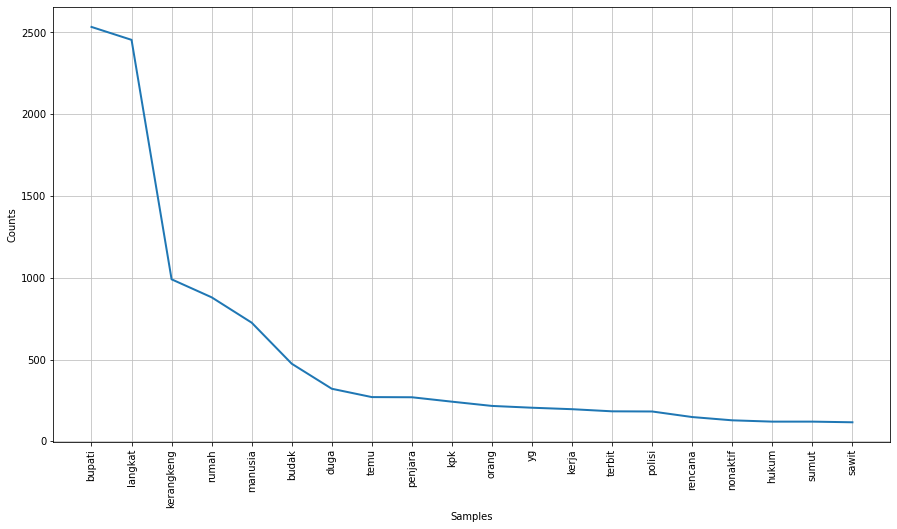

In [34]:
plt.figure(figsize=(15, 8))
fqdist.plot(20,cumulative=False)
plt.show()

##### Distribusi N-gram


In [35]:
result = pd.Series(nltk.ngrams(news_title, 2)).value_counts()[:20]
result

(bupati, langkat)        2270
(rumah, bupati)           684
(kerangkeng, manusia)     501
(manusia, rumah)          341
(kerangkeng, rumah)       193
(temu, kerangkeng)        153
(terbit, rencana)         144
(duga, budak)             131
(langkat, terbit)          99
(perangin, angin)          97
(rencana, perangin)        92
(budak, bupati)            88
(budak, modern)            86
(penjara, rumah)           82
(langkat, kerangkeng)      77
(kerangkeng, bupati)       76
(langkat, bupati)          73
(langkat, nonaktif)        72
(manusia, bupati)          65
(langkat, duga)            64
dtype: int64

### Data Insight

In [36]:
positive = df[df['sentiment'] == "Positive"]
print(str(positive.shape[0]/(df.shape[0])*100) + "%")
pos = positive.shape[0]/df.shape[0]*100

14.933333333333335%


In [37]:
negative = df[df['sentiment'] == "Negative"]
print(str(negative.shape[0]/(df.shape[0])*100) + "%")
neg =negative.shape[0]/df.shape[0]*100

44.766666666666666%


In [38]:
neutral = df[df['sentiment'] == "Neutral"]
print(str(neutral.shape[0]/(df.shape[0])*100) + "%")
net = neutral.shape[0]/df.shape[0]*100

40.300000000000004%


(-1.1502591876496258,
 1.1257311855144956,
 -1.2301002148142393,
 1.1242710195850218)

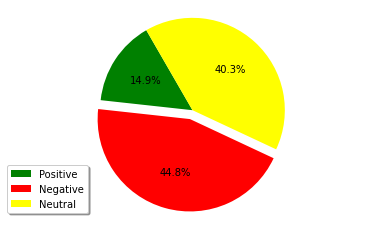

In [39]:
explode = (0,0.1,0)
labels = 'Positive', 'Negative','Neutral'
sizes = (pos, neg, net)
colors = ('green','red','yellow')

plt.pie(sizes, explode = explode, colors = colors, autopct = '%1.1f%%', startangle = 120)
plt.legend(labels, loc = (-0.05,0.05), shadow = True)
plt.axis('equal')

##### Insight

Sentiment Analysis menggunakan metode Natural Language Processing yang dilakukan pada kata kunci "Bupati Langkat" yang sedang hangat diberitan terkait kepemilikan kerangkeng manusia di rumahnya menunjukkan hasil yang sesuai dengan dugaan penulis. Setelah dilakukan Sentiment Analysis didapatkan Tweet yang berjumlah 3000 tweet bermuatan Negatif memiliki jumlah terbanyak yaitu sebanyak 1343 Tweet, sedangkan untuk tweet Netral sebanyak 1209 dan Positif sebanyak 448